# Battery Drain Analysis

This notebook analyzes the battery logs collected from an Android device using `adb`.

We will use the custom `parsing.py` module to process the raw log files and then visualize the key findings, such as:

*   Battery level decrease over time.
*   Top applications and components consuming power.

In [9]:
import pandas as pd
import parsing
import warnings
import re
import os

# which we can safely ignore for this analysis.
warnings.filterwarnings('ignore', category=UserWarning, module='seaborn')

# Configure pandas for better display in the notebook
pd.set_option('display.max_rows', 100)

print("Setup complete. Libraries and 'parsing.py' module imported.")

Setup complete. Libraries and 'parsing.py' module imported.


## Load and Process All Log Data

Here, we call the main processing function from our `parsing.py` script. It automatically finds all the log folders, parses the relevant files, and aggregates the data into two convenient pandas DataFrames.

In [10]:
print("Processing all log files from the 'logs' directory...")
battery_df, power_df, longwake_df = parsing.process_all_logs()
print("Data processing complete.")
parsing.display_device_info()

if not battery_df.empty:
    print("\n--- Sample of Battery Level Data ---")
    display(battery_df.head())

else:
    print("\nCould not load data. Ensure the 'logs' directory exists and contains valid log files.")

Processing all log files from the 'logs' directory...
Data processing complete.
--- Device Information (from latest log) ---
  Log Source: 2025-09-09_23-09
  Phone Model: IV2201
  Android OS Version: 13
  Estimated Battery Health: 65.7%

--- Sample of Battery Level Data ---


,level
timestamp,
2025-09-09 22:49:00,21
2025-09-09 22:58:00,18
2025-09-09 23:05:00,18
2025-09-09 23:09:00,18


## 1. Battery Level Over Time

The first step is to visualize the most direct metric: the battery percentage over the data collection period. This gives us a high-level overview of the discharge rate.

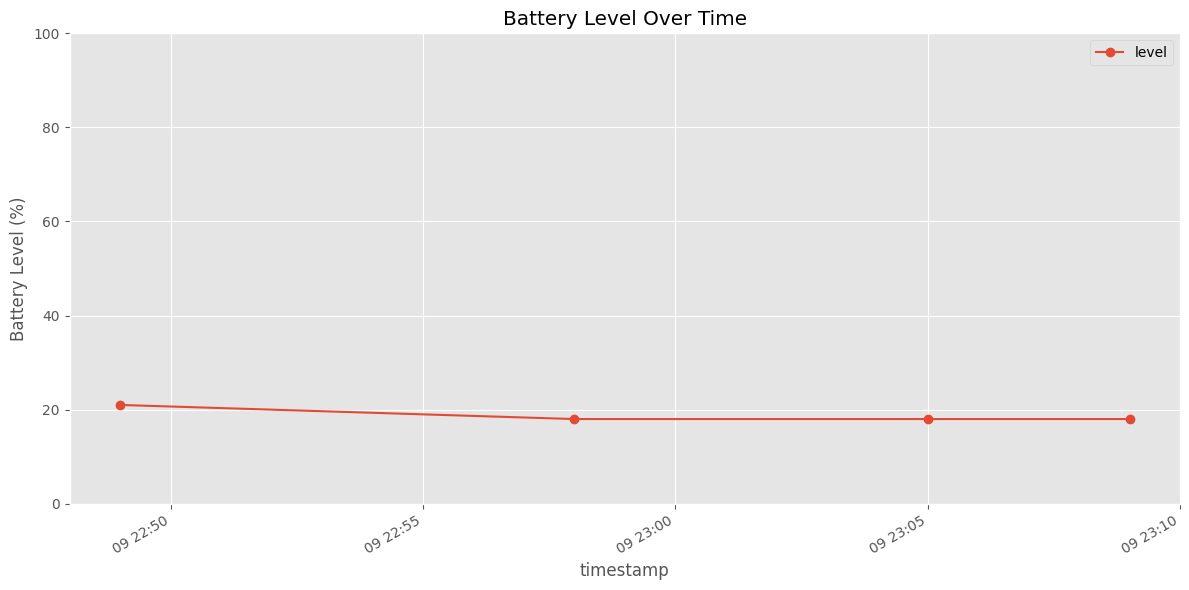

In [11]:
if not battery_df.empty:
    parsing.plot_battery_level(battery_df)
else:
    print("No battery level data was found to plot.")

## 2. Top Power Consumers

Next, we'll identify which specific applications and hardware components used the most power (measured in mAh) across the entire logging session. This is the most critical chart for identifying problematic apps.

The `batterystats` service provides an estimated power draw for each component. We sum these estimates from all the log files to get a total consumption figure.

c:\Users\user\Desktop\battery_proj\parsing.py:235: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='power_mah', y=y_col, data=top_consumers, ax=ax, palette='viridis')


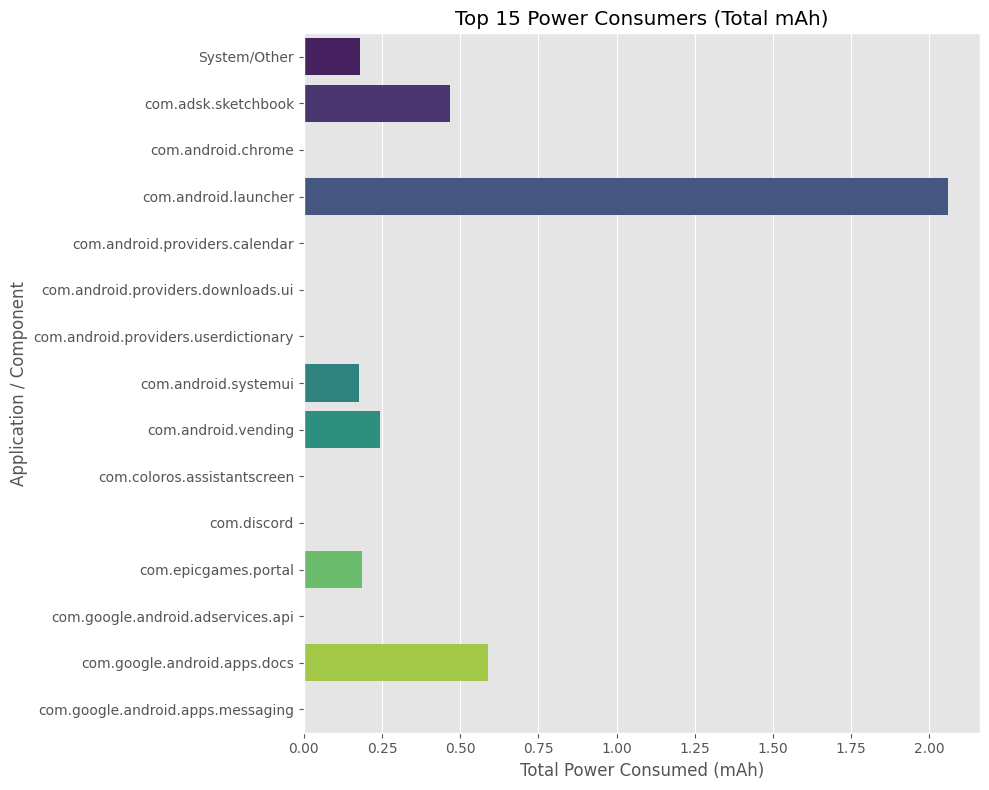

In [12]:
if not power_df.empty:
    # We can adjust the number of items to show in the plot by changing top_n
    parsing.plot_top_consumers(power_df, top_n=15)
else:
    print("No power consumption data was found to plot.")

## 3. Wakelock Analysis

Wakelocks are mechanisms that prevent the device from entering a deep sleep state. They are a common source of battery drain, especially if held for long periods. Here, we identify which applications or services are holding wakelocks the longest.

--- Top 15 Longwakes by Total Duration (in seconds) ---


,uid,tag,duration_s,app_name
0,u0a428,AudioMix,451.592,com.supercell.clashofclans
1,u0a156,AudioMix,290.820,com.google.android.youtube
2,u0a411,AudioMix,18.113,com.instagram.android
3,u0a411,ExoPlayer:WakeLockManager,3.902,com.instagram.android


c:\Users\user\Desktop\battery_proj\parsing.py:254: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='duration_s', y='label', data=top_items, ax=ax, palette='plasma')


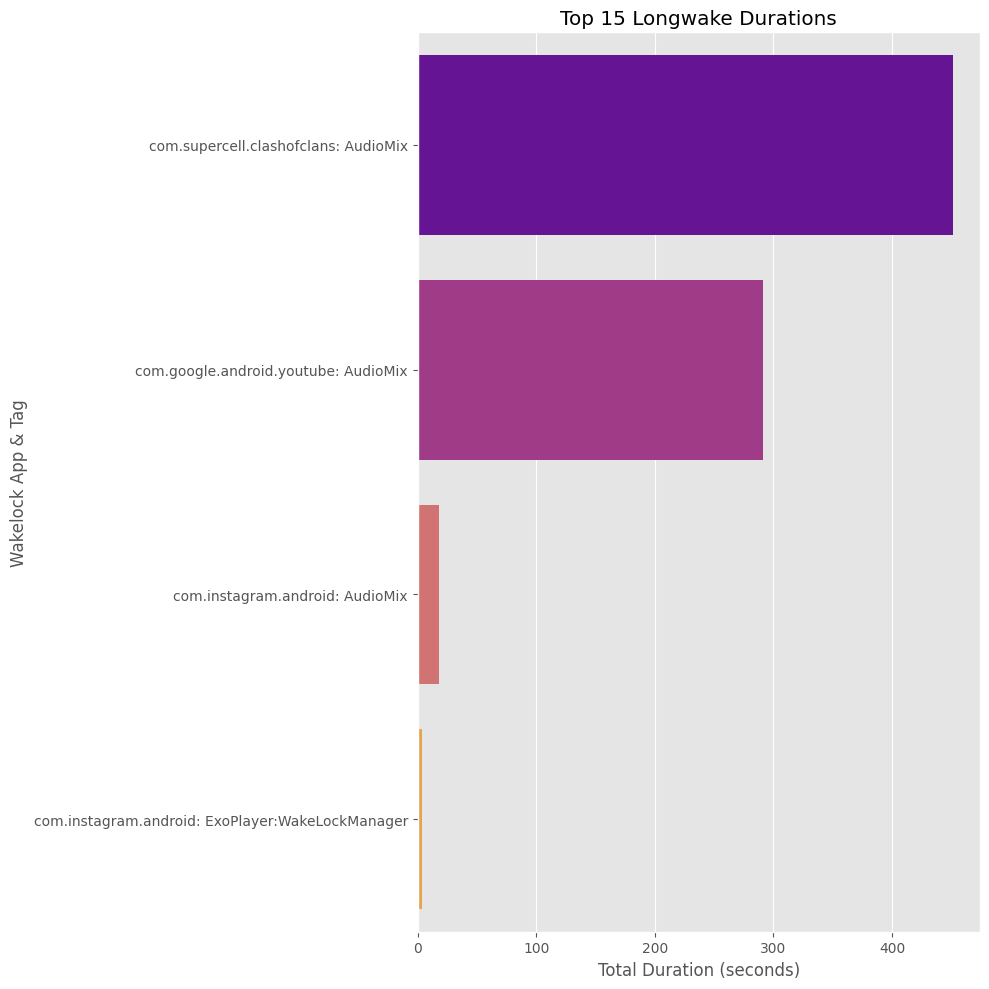

In [13]:
# Add this to a new cell for wakelock analysis
if not longwake_df.empty:
    print("--- Top 15 Longwakes by Total Duration (in seconds) ---")
    display(longwake_df.head(15))
    
    # Use the new plotting function for longwakes
    parsing.plot_top_longwakes(longwake_df, top_n=15)
else:
    print("No significant longwake data was found to analyze.")


## 4. Combined Analysis: Identifying Top Offenders

Now we'll correlate the two main sources of battery drain: direct power consumption (in mAh) and wakelocks (in seconds). An application that appears high on both lists is likely a primary target for optimization.

We will merge our two dataframes to see this relationship clearly.

In [14]:

def get_package_name_from_tag(tag):
    # This regex finds things that look like package names (e.g., com.snapchat.android)
    match = re.search(r'([a-zA-Z0-9_]+\\.[a-zA-Z0-9_\\.]+)', tag)
    return match.group(1) if match else 'System/Other'

if not longwake_df.empty:
    longwake_df['name'] = longwake_df['tag'].apply(get_package_name_from_tag)
    # Now, we sum up wakelock durations by the cleaned package name
    app_wakelocks = longwake_df.groupby('name')['duration_s'].sum().reset_index()

    # Merge the power consumption data with the wakelock data
    if not power_df.empty:
        # We use an 'outer' merge to keep all apps from both lists
        combined_df = pd.merge(power_df, app_wakelocks, on='name', how='outer').fillna(0)
        
        # We can create a simple 'score' to rank the worst offenders
        # This is a basic approach, you can tune the weighting
        combined_df['drain_score'] = (combined_df['power_mah'] * 0.7) + (combined_df['duration_s'] * 0.3)
        
        # Sort by the new score
        combined_df = combined_df.sort_values(by='drain_score', ascending=False)

        print("--- Combined Analysis: Top Battery Offenders ---")
        display(combined_df.head(15))
    else:
        print("Power consumption data is empty, cannot create combined analysis.")
else:
    print("Wakelock data is empty, cannot create combined analysis.")


--- Combined Analysis: Top Battery Offenders ---


,name,power_mah,duration_s,drain_score
0,System/Other,0.179250,764.427,229.453575
69,screen,170.400000,0.000,119.280000
68,mobile_radio,130.700000,0.000,91.490000
38,com.google.android.youtube,128.100000,0.000,89.670000
62,com.supercell.clashofclans,100.300000,0.000,70.210000
40,com.instagram.android,10.457000,0.000,7.319900
65,idle,6.744000,0.000,4.720800
49,com.openai.chatgpt,6.200000,0.000,4.340000
64,com.whatsapp,4.042000,0.000,2.829400
3,com.android.launcher,2.058572,0.000,1.441000


In [15]:
from getpass import getpass

# Run this cell, and it will prompt you to enter your key securely
api_key = getpass('Enter your Gemini API Key: ')
os.environ['GEMINI_API_KEY'] = api_key

print("GEMINI_API_KEY has been set for this notebook session.")

GEMINI_API_KEY has been set for this notebook session.


In [16]:
from google import genai
from IPython.display import display, Markdown

if 'GEMINI_API_KEY' not in os.environ:
    print("ERROR: Please set the GEMINI_API_KEY environment variable before running this cell.")
else:
    client = genai.Client()

    # Prepare the data and prompt
    # Select the top 10 offenders to send to the model
    top_offenders_df = combined_df.head(10)
    offenders_csv = top_offenders_df.to_csv(index=False)

    prompt = f"""You are an expert Android battery life analyst.

    I have collected battery statistics from my Android device. The following CSV data contains the top battery-draining processes, including their direct power consumption in mAh (`power_mah`) and the total time they held a wakelock in seconds (`duration_s`). A high `drain_score` indicates a worse offender.
    The columns in the data represent the following:

    *   **`power_mah`**: The total power consumed by a process, measured in milliampere-hours (mAh). This is a direct measure of battery used.
    *   **`duration_s`**: The total time in seconds a process held a wakelock, preventing the device from entering a low-power sleep state.
    *   **`drain_score`**: A calculated score to rank the worst offenders. It is a weighted sum calculated as `(power_mah * 0.7) + (duration_s * 0.3)`.

    **Data:**
    ```csv
    {offenders_csv}
    ```

    Please provide a detailed analysis and report with the following sections:

    1.  **Top Offenders Analysis:** Briefly describe the top 3-5 processes from the list. What is their likely function on the device?

    2.  **System vs. User Apps:** Differentiate between which of these are critical system processes and which are user-installed applications.

    3.  **Potential Reasons for Drain:** For the top offenders, explain the most likely reasons for their high battery consumption based on the data (e.g., high `power_mah` suggests active use, while high `duration_s` suggests background activity or poor sleep behavior).

    4.  **Actionable Recommendations:** Provide a clear, bulleted list of potential solutions or steps a user can take to improve their battery life based on this specific data.
    """

    # 4. Generate the report
    print("Generating battery analysis report with Gemini...")
    try:
        response = client.models.generate_content(
            model='gemini-2.5-pro',
            contents=prompt
        )
        
        print("Report generation complete.")
        display(Markdown(response.text))

    except Exception as e:
        print(f"\\nAn error occurred: {e}")
        print("Please ensure the 'google-genai' library is installed (`pip install google-genai`) and your API key is correct.")

Generating battery analysis report with Gemini...
Report generation complete.


Of course. As an Android battery life analyst, I have reviewed the provided battery statistics. Here is a detailed report and analysis of your device's power consumption.

***

### **Android Battery Life Analysis Report**

This report analyzes the battery consumption data from your device to identify the primary sources of drain and provide actionable recommendations for improving battery longevity.

---

### 1. Top Offenders Analysis

The processes with the highest `drain_score` are the most significant contributors to battery consumption. Based on your data, the top offenders are:

1.  **System/Other (Drain Score: 229.45):** This is a broad, catch-all category that represents a combination of low-level system processes, kernel operations, and sometimes, power usage that the Android system cannot attribute to a specific app. Its function is to manage the core operations of the device.

2.  **screen (Drain Score: 119.28):** This represents the physical display of your device. It is not an app but a hardware component whose power consumption is directly related to how long it is turned on and at what brightness level.

3.  **mobile_radio (Drain Score: 91.49):** This is the hardware component responsible for connecting to your cellular network (4G/5G/LTE). Its power usage is dictated by signal strength and the amount of data being sent and received over the cellular connection.

4.  **com.google.android.youtube (Drain Score: 89.67):** This is the official Google YouTube application. Its primary function is streaming and playing video content, which is a resource-intensive task.

5.  **com.supercell.clashofclans (Drain Score: 70.21):** This is a popular mobile game. Gaming applications are typically heavy on the CPU, GPU, and screen, leading to high power consumption during active use.

---

### 2. System vs. User Apps

It is crucial to distinguish between core system functions and user-installed applications to understand what can be controlled.

*   **System Processes & Hardware Components:**
    *   `System/Other`: Core Android OS and kernel processes.
    *   `screen`: The physical display hardware.
    *   `mobile_radio`: The cellular modem hardware.
    *   `idle`: Represents the time the CPU was in a low-power sleep state. This is good; it shows the device *was* able to sleep at times.
    *   `com.android.launcher`: The app responsible for your home screen and app drawer. It is a fundamental part of the user interface.

*   **User-Installed Applications:**
    *   `com.google.android.youtube`: YouTube app.
    *   `com.supercell.clashofclans`: Clash of Clans game.
    *   `com.instagram.android`: Instagram app.
    *   `com.openai.chatgpt`: ChatGPT app.
    *   `com.whatsapp`: WhatsApp messaging app.

---

### 3. Potential Reasons for Drain

The data provides clear indicators of *why* each process is consuming power.

*   **System/Other:** The most critical finding is here. While its direct power consumption (`power_mah`) is negligible at **0.179 mAh**, it held a **wakelock for 764.4 seconds** (nearly 13 minutes). A wakelock prevents the device's CPU from entering its deep sleep state. This means something in the system is misbehaving and keeping the device partially awake in the background, leading to significant "phantom" drain even when the screen is off. **This is the primary background issue to be addressed.**

*   **screen, youtube, clashofclans:** These processes have high `power_mah` values but **zero (`0.0`) wakelock duration**. This pattern indicates that their battery drain is almost exclusively due to **active, foreground usage**. The battery was consumed while you were actively using the device with the screen on, watching videos, or playing games. This is expected behavior for these types of activities and does not suggest a background problem.

*   **mobile_radio:** Similar to the screen, its drain is from active use. The high consumption of **130.7 mAh** strongly suggests that you were either in an area with **poor cellular signal strength** (forcing the radio to use more power to maintain a connection) or were heavily using mobile data for streaming or downloading.

---

### 4. Actionable Recommendations

Based on this analysis, here are specific steps you can take to improve your battery life, prioritized by impact.

#### **Priority 1: Address the "System/Other" Wakelock**
This is the most abnormal and impactful issue. Your goal is to stop whatever is preventing the device from sleeping.

*   **Reboot Your Device:** A simple restart can often terminate a stuck process that is causing a persistent wakelock. This should always be your first step.
*   **Check for System Updates:** The wakelock could be caused by a known bug in the Android OS. Go to `Settings > System > System update` to ensure your device is running the latest software version.
*   **Review Recently Installed or Updated Apps:** A poorly coded third-party app can sometimes cause system-level wakelocks. If this problem started recently, consider uninstalling apps you installed just before the drain began.

#### **Priority 2: Manage High-Consumption Hardware**
These actions will reduce the drain from your screen and cellular radio.

*   **Reduce Screen Brightness:** The screen is your second-biggest drainer. Lowering the brightness manually or enabling "Adaptive Brightness" is the single most effective way to reduce its power consumption.
*   **Use a Shorter Screen Timeout:** Set your screen to turn off more quickly when not in use (e.g., 30 seconds) via `Settings > Display > Screen timeout`.
*   **Prioritize Wi-Fi over Mobile Data:** The `mobile_radio` drain is significant. Wi-Fi connections are far more power-efficient than cellular. Connect to Wi-Fi whenever a trusted network is available.
*   **Toggle Airplane Mode in No-Signal Areas:** If you are in a location with no or very poor cell service, your phone will constantly search for a signal, draining the battery. Toggling Airplane Mode in these situations will prevent this.

#### **Priority 3: Optimize App Usage**
The drain from apps like YouTube and Clash of Clans is from active use, so these tips focus on managing that usage.

*   **Limit Screen-On Time with Intensive Apps:** Acknowledge that gaming and video streaming are battery-heavy tasks. Reducing time spent on them will directly save battery.
*   **Download Video Content for Offline Viewing:** When using YouTube, download videos over Wi-Fi for later viewing. This avoids the combined battery hit of using the screen and the power-hungry mobile radio simultaneously.
*   **Adjust In-Game Settings:** For games like `Clash of Clans`, check if there are in-game settings to lower graphics quality or limit the frame rate (FPS). This can significantly reduce CPU/GPU load and save power.